In [ ]:
%pip install sagemaker -qU

In [ ]:
from IPython import get_ipython
get_ipython().kernel.do_shutdown(True)

# Demand Forecasting with XGBoost on Amazon SageMaker

This notebook demonstrates how to:
1. Prepare a synthetic demand forecasting dataset
2. Train an XGBoost model on Amazon SageMaker
3. Deploy the model to a SageMaker endpoint for real-time inference

The workflow includes:
- Generating synthetic time series data with trend, seasonality, and noise
- Feature engineering for time series forecasting
- Training an XGBoost model on SageMaker
- Deploying the model to a SageMaker endpoint
- Testing the endpoint with sample data

## Setup and Imports

In [1]:
import boto3
import sagemaker
import pandas as pd
import numpy as np
from sagemaker.xgboost.estimator import XGBoost
from sagemaker.serializers import CSVSerializer
from sagemaker.deserializers import JSONDeserializer
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
import os

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/sagemaker-user/.config/sagemaker/config.yaml


## Initialize SageMaker Session

In [2]:
# Initialize SageMaker session
session = sagemaker.Session()
bucket = session.default_bucket()
region = boto3.Session().region_name

try:
    role = sagemaker.get_execution_role()
except:
    role = input("> Enter the role ARN for your SageMaker execution role: ")
    role = role.strip()

print(f"SageMaker session initialized in region: {region}")
print(f"Using S3 bucket: {bucket}")
print(f"Using IAM role: {role}")

SageMaker session initialized in region: us-east-1
Using S3 bucket: sagemaker-us-east-1-859755744029
Using IAM role: arn:aws:iam::859755744029:role/service-role/SageMaker-ExecutionRole-20250226T142578


## Generate Synthetic Demand Data

We'll create synthetic time series data with trend, seasonality, and noise components to simulate demand patterns.

In [3]:
def generate_demand_data(n_periods=365*2, seasonality=True, trend=True, noise_level=0.2):
    """Generate synthetic demand data with trend, seasonality, and noise."""
    time_idx = np.arange(n_periods)
    
    # Base demand
    base_demand = 100
    
    # Add trend component
    trend_component = 0
    if trend:
        trend_component = time_idx * 0.1
    
    # Add seasonality component
    seasonality_component = 0
    if seasonality:
        # Weekly seasonality
        weekly = 10 * np.sin(2 * np.pi * time_idx / 7)
        # Monthly seasonality
        monthly = 20 * np.sin(2 * np.pi * time_idx / 30)
        # Yearly seasonality
        yearly = 50 * np.sin(2 * np.pi * time_idx / 365)
        
        seasonality_component = weekly + monthly + yearly
    
    # Add noise
    noise = np.random.normal(0, noise_level * base_demand, n_periods)
    
    # Combine components
    demand = base_demand + trend_component + seasonality_component + noise
    
    # Ensure no negative values
    demand = np.maximum(demand, 0)
    
    # Create DataFrame
    dates = pd.date_range(start='2021-01-01', periods=n_periods)
    df = pd.DataFrame({
        'date': dates,
        'demand': demand
    })
    
    # Add date features
    df['dayofweek'] = df['date'].dt.dayofweek
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['year'] = df['date'].dt.year
    df['quarter'] = df['date'].dt.quarter
    
    return df

# Generate data
print("Generating synthetic demand forecasting data...")
df = generate_demand_data()
print(f"Dataset shape: {df.shape}")
df.head()

Generating synthetic demand forecasting data...
Dataset shape: (730, 7)


,date,demand,dayofweek,month,day,year,quarter
0,2021-01-01,106.566152,4,1,1,2021,1
1,2021-01-02,78.742194,5,1,2,2021,1
2,2021-01-03,109.920671,6,1,3,2021,1
3,2021-01-04,119.603332,0,1,4,2021,1
4,2021-01-05,113.589446,1,1,5,2021,1


## Visualize the Data

Let's visualize the synthetic demand data to understand its patterns.

<module 'matplotlib.pyplot' from '/opt/conda/lib/python3.11/site-packages/matplotlib/pyplot.py'>

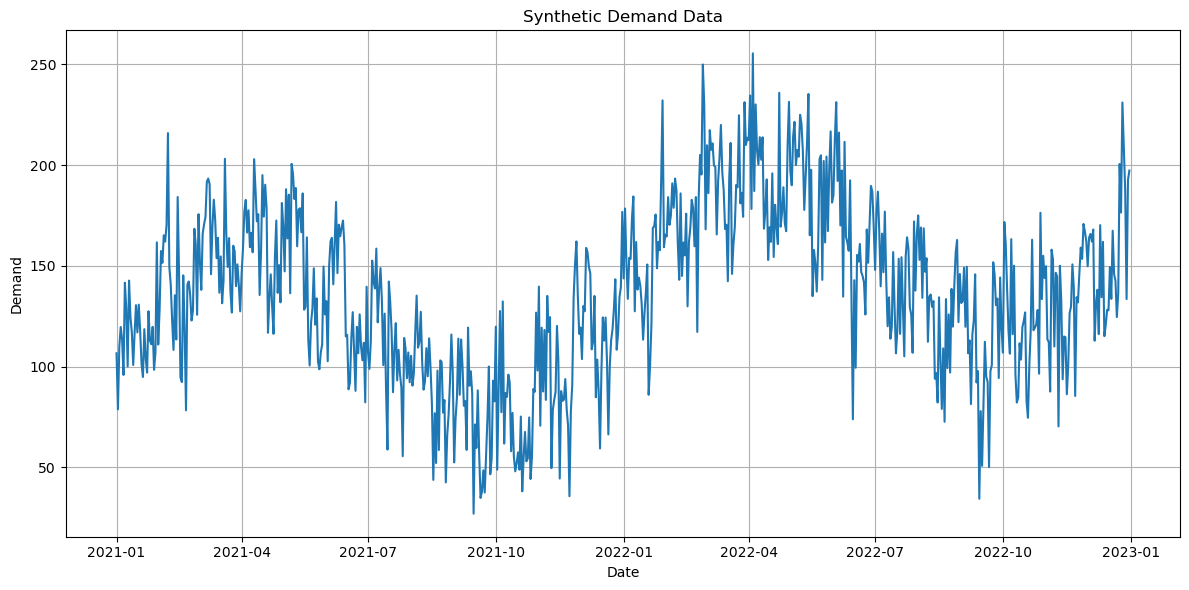

In [4]:
def visualize_data(df):
    """Visualize the demand data."""
    plt.figure(figsize=(12, 6))
    plt.plot(df['date'], df['demand'])
    plt.title('Synthetic Demand Data')
    plt.xlabel('Date')
    plt.ylabel('Demand')
    plt.grid(True)
    plt.tight_layout()
    return plt

# Visualize data
visualize_data(df)

## Feature Engineering

Create lag and rolling window features for time series forecasting.

In [5]:
def prepare_features(df):
    """Create lag and rolling features for time series forecasting."""
    # Create lag features (previous demand values)
    for lag in [1, 7, 14, 30]:
        df[f'lag_{lag}'] = df['demand'].shift(lag)

    # Create rolling window features
    for window in [7, 14, 30]:
        df[f'rolling_mean_{window}'] = df['demand'].rolling(window=window).mean()
        df[f'rolling_std_{window}'] = df['demand'].rolling(window=window).std()

    # Drop rows with NaN values (due to lag and rolling features)
    df = df.dropna()
    
    return df

# Prepare features
df = prepare_features(df)
print(f"Dataset shape after feature engineering: {df.shape}")
df.head()

Dataset shape after feature engineering: (700, 17)


,date,demand,dayofweek,month,day,year,quarter,lag_1,lag_7,lag_14,lag_30,rolling_mean_7,rolling_std_7,rolling_mean_14,rolling_std_14,rolling_mean_30,rolling_std_30
30,2021-01-31,110.910506,6,1,31,2021,1,161.630575,127.439092,130.705546,106.566152,117.369814,20.554235,113.012735,16.956534,115.004595,16.818008
31,2021-02-01,128.421119,0,2,1,2021,1,110.910506,112.944735,117.651610,78.742194,119.580727,20.829437,113.781986,17.421091,116.660559,15.520055
32,2021-02-02,157.330060,1,2,2,2021,1,128.421119,111.047296,101.204847,109.920671,126.192550,24.662292,117.790929,20.491414,118.240872,17.139340
33,2021-02-03,151.478997,2,2,3,2021,1,157.330060,119.702274,94.801428,119.603332,130.732082,26.148299,121.839327,21.187061,119.303394,18.182978
34,2021-02-04,165.118682,3,2,4,2021,1,151.478997,98.355304,118.534653,113.589446,140.269707,24.494283,125.166758,24.087607,121.021035,19.970567


## Split Data into Train, Validation, and Test Sets

In [6]:
def split_data(df):
    """Split data into features and target, then into train/val/test sets."""
    # Define features and target
    features = [col for col in df.columns if col not in ['date', 'demand']]
    X = df[features]
    y = df['demand']

    # Split data into train, validation, and test sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, shuffle=False)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=False)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# Split data
X_train, y_train, X_val, y_val, X_test, y_test = split_data(df)
print(f"Training set: {X_train.shape}")
print(f"Validation set: {X_val.shape}")
print(f"Test set: {X_test.shape}")

Training set: (490, 15)
Validation set: (105, 15)
Test set: (105, 15)


## Save Data to S3

Save the datasets to CSV files and upload them to S3 for SageMaker training.

In [7]:
def save_data_to_s3(X_train, y_train, X_val, y_val, X_test, y_test, session, bucket):
    """Save datasets to CSV and upload to S3."""
    # Create local directories for data
    os.makedirs('data', exist_ok=True)

    # Save datasets to CSV
    train_data = pd.concat([X_train, y_train], axis=1)
    val_data = pd.concat([X_val, y_val], axis=1)
    test_data = pd.concat([X_test, y_test], axis=1)

    train_data.to_csv('data/train.csv', index=False)
    val_data.to_csv('data/validation.csv', index=False)
    test_data.to_csv('data/test.csv', index=False)

    # Upload to S3
    train_s3_path = session.upload_data('data/train.csv', bucket=bucket, key_prefix='demand-forecast/data')
    val_s3_path = session.upload_data('data/validation.csv', bucket=bucket, key_prefix='demand-forecast/data')
    test_s3_path = session.upload_data('data/test.csv', bucket=bucket, key_prefix='demand-forecast/data')
    
    return train_s3_path, val_s3_path, test_s3_path

# Save data to S3
train_s3_path, val_s3_path, test_s3_path = save_data_to_s3(
    X_train, y_train, X_val, y_val, X_test, y_test, session, bucket
)
print(f"Training data uploaded to: {train_s3_path}")
print(f"Validation data uploaded to: {val_s3_path}")
print(f"Test data uploaded to: {test_s3_path}")

Training data uploaded to: s3://sagemaker-us-east-1-859755744029/demand-forecast/data/train.csv
Validation data uploaded to: s3://sagemaker-us-east-1-859755744029/demand-forecast/data/validation.csv
Test data uploaded to: s3://sagemaker-us-east-1-859755744029/demand-forecast/data/test.csv


## Train XGBoost Model on SageMaker

Define and train an XGBoost model using SageMaker's training infrastructure.

In [31]:
def train_model(train_s3_path, val_s3_path, role, bucket, instance_type='ml.m5.4xlarge'):
    """Train XGBoost model on SageMaker."""
    # Define XGBoost hyperparameters
    hyperparameters = {
        'max_depth': 6,
        'eta': 0.2,
        'gamma': 4,
        'min_child_weight': 6,
        'subsample': 0.8,
        'objective': 'reg:squarederror',
        'num_round': 100,
        'verbosity': 1
    }

    # Create XGBoost estimator
    xgb_estimator = XGBoost(
        entry_point='script.py',  # SageMaker will use a built-in script
        framework_version='1.5-1',
        hyperparameters=hyperparameters,
        role=role,
        instance_count=1,
        instance_type=instance_type,
        output_path=f's3://{bucket}/demand-forecast/output',
        keep_alive_period_in_seconds=3600,
    )

    # Train the model
    print("Training XGBoost model...")
    xgb_estimator.fit({'train': train_s3_path, 'validation': val_s3_path})
    
    return xgb_estimator

# Train model (Note: This cell will take some time to execute)
# You can change the instance_type parameter to use a different instance type
instance_type = 'ml.m5.4xlarge'  # You can change this to a smaller instance if needed
xgb_estimator = train_model(train_s3_path, val_s3_path, role, bucket, instance_type)

INFO:sagemaker.image_uris:Ignoring unnecessary Python version: py3.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: ml.m5.4xlarge.
INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2025-05-28-13-35-51-310


Training XGBoost model...
2025-05-28 13:35:51 Starting - Starting the training job...
2025-05-28 13:36:14 Starting - Preparing the instances for training...
2025-05-28 13:36:51 Downloading - Downloading the training image...
2025-05-28 13:37:26 Training - Training image download completed. Training in progress...../miniconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
[2025-05-28 13:37:55.732 ip-10-0-139-16.ec2.internal:7 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2025-05-28 13:37:55.753 ip-10-0-139-16.ec2.internal:7 INFO profiler_config_parser.py:111] User has disabled profiler.
[2025-05-28:13:37:56:INFO] Imported framework sagemaker_xgboost_container.training
[2025-05-28:13:37:56:INFO] No GPUs detected (normal if no gpus installed)
[2025-05-28:13:37:56:INFO] Invoking user

## Deploy Model to SageMaker Endpoint

Deploy the trained model to a SageMaker endpoint for real-time inference.

In [ ]:
from sagemaker.serializers import JSONSerializer

def deploy_model(xgb_estimator, instance_type='ml.m5.xlarge'):
    """Deploy model to SageMaker endpoint."""
    print("Deploying model to SageMaker endpoint...")
    predictor = xgb_estimator.deploy(
        endpoint_name="ml-models-as-tools",
        initial_instance_count=1,
        instance_type=instance_type,
        serializer=JSONSerializer(),
        deserializer=JSONDeserializer()
    )
    
    endpoint_name = predictor.endpoint_name
    print(f"Model deployed to endpoint: {endpoint_name}")
    
    return predictor

# Deploy model
# You can change the instance_type parameter to use a different instance type
deploy_instance_type = 'ml.m5.xlarge'  # You can change this to a smaller instance if needed
predictor = deploy_model(xgb_estimator, deploy_instance_type)

Deploying model to SageMaker endpoint...


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2025-05-28-13-38-38-317
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2025-05-28-13-38-38-317
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2025-05-28-13-38-38-317


--------!Model deployed to endpoint: sagemaker-xgboost-2025-05-28-13-38-38-317


## Test the Endpoint

Test the deployed endpoint with sample data from the test set.

In [42]:
test_sample = X_test.iloc[:5].values.tolist()
actual = y_test.iloc[:5].values

In [51]:
test_sample

[[6.0,
  9.0,
  18.0,
  2022.0,
  3.0,
  82.32242989519233,
  145.7780143415423,
  119.72411707626237,
  109.00943866750897,
  78.1850279953027,
  27.17729231087614,
  98.725083103897,
  32.3663008574393,
  114.30045179438677,
  31.154757059649896],
 [0.0,
  9.0,
  19.0,
  2022.0,
  3.0,
  112.29372828348961,
  92.05548651574294,
  149.53457153115409,
  72.54645882732314,
  78.59649696115221,
  27.4428007288024,
  94.82516865714953,
  28.874170960965433,
  115.04676214269898,
  30.378550374126004],
 [1.0,
  9.0,
  20.0,
  2022.0,
  3.0,
  94.93576927668948,
  97.7187873924136,
  106.5675777935643,
  133.46975024736352,
  77.82557137676875,
  26.886240262965835,
  93.80764940773277,
  28.67887997302126,
  113.67518074451117,
  30.4468958883678],
 [2.0,
  9.0,
  21.0,
  2022.0,
  3.0,
  92.32230830172934,
  34.350356241745,
  112.97609292100049,
  99.21268633211206,
  80.06729855054992,
  23.0356600622431,
  89.31238894610509,
  30.32804828287802,
  112.03617274871455,
  32.5061062272653

In [ ]:
import boto3, json

def generate_prediction_with_boto3(endpoint_name, test_sample):
    sagemaker_runtime = boto3.client("sagemaker-runtime")
    response = sagemaker_runtime.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(test_sample),
        ContentType="application/json",
        Accept="application/json"
    )
    predictions = json.loads(response['Body'].read().decode("utf-8"))
    return np.array(predictions)

generate_prediction_with_boto3("ml-models-as-tools", test_sample)

array([89.8525238 , 52.51485062, 58.35247421, 62.79786301, 85.51475525])

In [35]:
def test_endpoint(predictor, test_sample, actual):
    """Test the endpoint with sample data."""

    # Make predictions
    print("Testing the endpoint with sample data...")
    predictions = predictor.predict(test_sample)
    predicted = np.array(predictions)

    # Compare predictions with actual values
    print("Sample predictions:")
    for i in range(len(actual)):
        print(f"Actual: {actual[i]:.2f}, Predicted: {predicted[i]:.2f}")

    # Calculate error metrics
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mean_squared_error(actual, predicted))
    print(f"Mean Absolute Error: {mae:.2f}")
    print(f"Root Mean Squared Error: {rmse:.2f}")
    
    return mae, rmse

# Test endpoint
mae, rmse = test_endpoint(predictor, test_sample, actual)

Testing the endpoint with sample data...
Sample predictions:
Actual: 112.29, Predicted: 89.85
Actual: 94.94, Predicted: 52.51
Actual: 92.32, Predicted: 58.35
Actual: 50.04, Predicted: 62.80
Actual: 97.76, Predicted: 85.51
Mean Absolute Error: 24.77
Root Mean Squared Error: 27.46


## Visualize Predictions

Let's visualize the predictions against actual values for a larger portion of the test set.

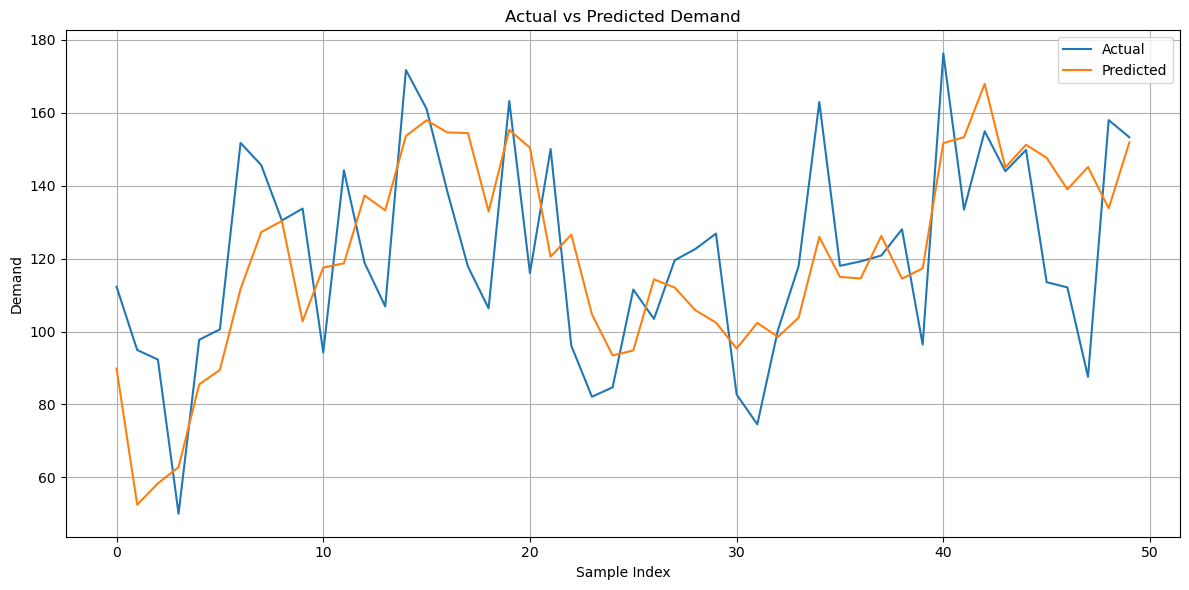

In [36]:
# Get predictions for more test samples
n_samples = 50  # Number of samples to predict
test_samples = X_test.iloc[:n_samples].values.tolist()
predictions = predictor.predict(test_samples)
actual = y_test.iloc[:n_samples].values

# Plot actual vs predicted
plt.figure(figsize=(12, 6))
plt.plot(range(len(actual)), actual, label='Actual')
plt.plot(range(len(predictions)), predictions, label='Predicted')
plt.title('Actual vs Predicted Demand')
plt.xlabel('Sample Index')
plt.ylabel('Demand')
plt.legend()
plt.grid(True)
plt.tight_layout()

## Clean Up Resources (Optional)

Delete the endpoint to avoid incurring charges when you're done.

In [29]:
# Uncomment and run this cell to delete the endpoint
print("Cleaning up: deleting endpoint...")
predictor.delete_endpoint()
print("Endpoint deleted.")

INFO:sagemaker:Deleting endpoint configuration with name: sagemaker-xgboost-2025-05-28-13-05-52-248


Cleaning up: deleting endpoint...


INFO:sagemaker:Deleting endpoint with name: sagemaker-xgboost-2025-05-28-13-05-52-248


Endpoint deleted.


## Conclusion

In this notebook, we've demonstrated how to:
1. Generate synthetic demand data with trend, seasonality, and noise
2. Create time series features using lag and rolling window techniques
3. Train an XGBoost model on Amazon SageMaker
4. Deploy the model to a SageMaker endpoint
5. Test the endpoint with real-time predictions

This workflow can be adapted for real-world demand forecasting applications by replacing the synthetic data with actual historical demand data.